#### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

2025-01-04 02:27:53.659567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735937873.670448  169809 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735937873.673735  169809 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-04 02:27:53.686264: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11040445708177024046
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9379840000
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16016060118127100581
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:06:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


I0000 00:00:1735937875.195060  169809 gpu_device.cc:2022] Created device /device:GPU:0 with 8945 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:06:00.0, compute capability: 8.6


In [3]:
## This disables GPU , forced to CPU

# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

## Preparing and Processing the Data

In [4]:
movie_reviews = pd.read_csv("a1_IMDB_Dataset.csv")

In [5]:
movie_reviews.shape

(50000, 2)

In [6]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
movie_reviews.isnull().sum()

review       0
sentiment    0
dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

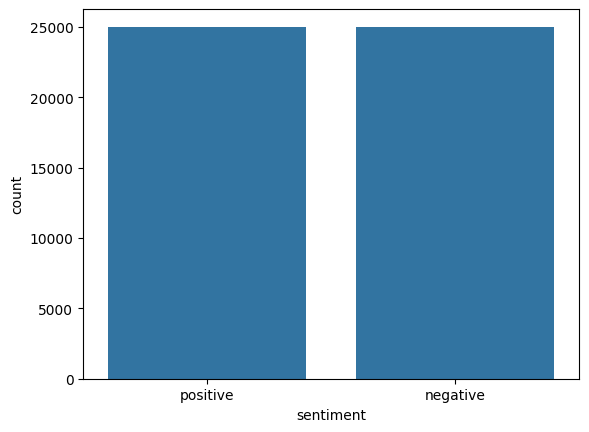

In [8]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

In [9]:
movie_reviews['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [5]:
# If you see this review, it has html tags or any unecessary symbols we have to delete it

## Cleaning the Data

In [10]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jd1t/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
def preprocess_text(sen):    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [13]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

### Converting using Binary Encoding

In [14]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [8]:
## No need to explain this. 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [10]:
# tokenizes the text data, converting the text into sequences of integers based on the word frequency.


In [16]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [12]:
# calculates size of vocal i.e. total no of unique words
# adding 1, well because word index should not be greater than vocab size in embedding layer 
# https://stackoverflow.com/questions/67293182/reason-for-adding-1-to-word-index-for-sequence-modeling

In [17]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [ ]:
# to ensure they are all of equal length that is 100 here and adding to each sequence

In [18]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
# used Glove here, maps each word to its vector 

In [19]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# construct embedding matrix which here is 100 dim vector from glove , this matrix will provide word representations udring traingin 

In [20]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [21]:
embedding_matrix.shape

(92394, 100)

## LSTM

In [23]:
from keras.layers import LSTM

In [13]:
## Sequential LSTM with Glove embedding layer followed by lstm layer and finally sigmoid activation for binary classification 

In [24]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

I0000 00:00:1735937898.050518  169809 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8945 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:06:00.0, compute capability: 8.6


In [14]:
# Compiles model with adam optimizer, accuracy as metric 
# Prints the model summary

In [25]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [15]:
# Train the model having batch size of 128 for 6 epochs

In [26]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6


I0000 00:00:1735937899.840461  169975 cuda_dnn.cc:529] Loaded cuDNN version 90501


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - acc: 0.6818 - loss: 0.5876 - val_acc: 0.8084 - val_loss: 0.4235
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.8064 - loss: 0.4304 - val_acc: 0.8311 - val_loss: 0.3890
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.8268 - loss: 0.3930 - val_acc: 0.8413 - val_loss: 0.3739
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.8388 - loss: 0.3737 - val_acc: 0.8389 - val_loss: 0.3578
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.8600 - loss: 0.3301 - val_acc: 0.8610 - val_loss: 0.3250
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.8698 - loss: 0.3087 - val_acc: 0.8529 - val_loss: 0.3407


In [16]:
# Evaluates returning loss and accuracy score

In [27]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8542 - loss: 0.3426 


In [17]:
# Summary above has ?? because i didnt had yet passed the input 

In [28]:
print(lstm_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (128, 100, 100)        │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (128, 128)             │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (128, 1)               │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,591,533 (36.59 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 9,239,400 (35.25 MB)

 Optimizer params: 234,756 (917.02 KB)

None


In [18]:
# Self explainotary

In [29]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.34347790479660034
Test Accuracy: 0.8529000282287598


In [19]:
## Plotting 

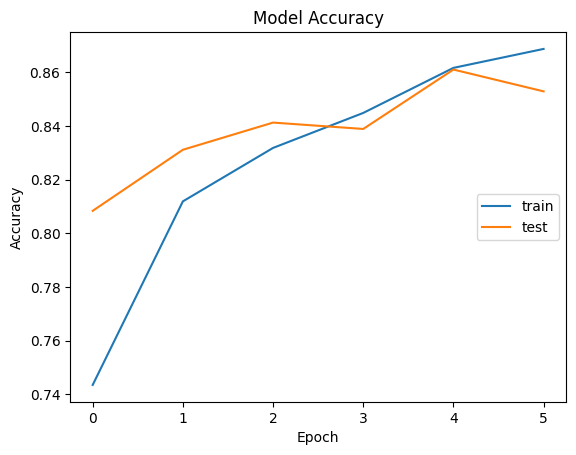

In [30]:
plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='center right')
plt.show()

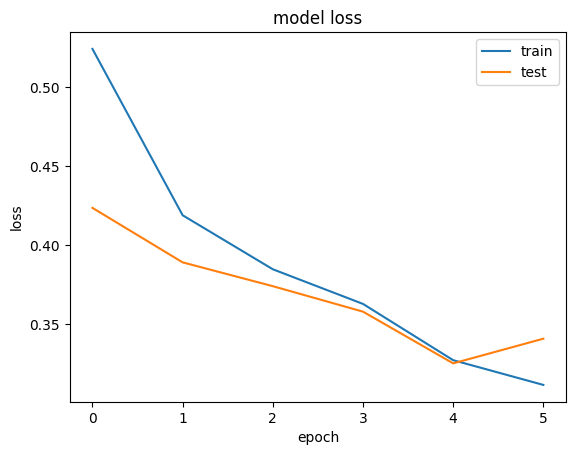

In [31]:
plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper right')
plt.show()

In [32]:
## Just Testing Purpose

In [33]:
reviews = [
    "This movie was a thrilling rollercoaster from start to finish, filled with unexpected twists and emotional depth.",
    "The plot was predictable and lacked originality. The characters were flat, making it hard to connect with them.",
    "Visually stunning and highly creative, but the pacing was slow, which made it hard to stay engaged throughout.",
    "An absolute masterpiece! The acting was superb, and the storyline was both gripping and emotionally powerful.",
    "A good movie overall, but it suffered from some clichés. Still enjoyable for fans of the genre."
]

ratings = [8, 1, 9, 10, 6]

df = pd.DataFrame({
    'Review': reviews,
    'Rating': ratings
})

In [34]:
unseen_reviews = df['Review']
unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [35]:
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [36]:
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


array([[0.97152036],
       [0.00647334],
       [0.97158855],
       [0.97170264],
       [0.34913337]], dtype=float32)

In [37]:
df['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)
df

,Review,Rating,Predicted Sentiments
0,This movie was a thrilling rollercoaster from ...,8,9.7
1,The plot was predictable and lacked originalit...,1,0.1
2,"Visually stunning and highly creative, but the...",9,9.7
3,An absolute masterpiece! The acting was superb...,10,9.7
4,"A good movie overall, but it suffered from som...",6,3.5


In [38]:
# Now the saving part

In [39]:
# lstm_model.save(r"./lstm_imdb_review.h5", save_format='h5')

In [40]:
# lstm_model.save('./lstm-imdb-review.h5')

In [20]:
### Under is all just testing with different input that's it 

In [41]:
review_text = """It is no wonder that the film has such a high rating, it is quite literally breathtaking. What can I say that hasn't been said before? Not much, it's the story, the acting, the premise, but most of all, this movie is about how it makes you feel. Sometimes you watch a film, and can't remember it days later, this film lives with you, once you've seen it, you don't forget.

The ultimate story of friendship, of hope, and of life, and overcoming adversity.

I understand why so many class this as the best film of all time, it isn't mine, but I get it. If you haven't seen it, or haven't seen it for some time, you need to watch it, it's amazing. 10/10."""


In [42]:
reviews.append(review_text)

In [43]:
ratings = [8, 1, 9, 10, 6,10]

df = pd.DataFrame({
    'Review': reviews,
    'Rating': ratings
})

In [44]:
df

,Review,Rating
0,This movie was a thrilling rollercoaster from ...,8
1,The plot was predictable and lacked originalit...,1
2,"Visually stunning and highly creative, but the...",9
3,An absolute masterpiece! The acting was superb...,10
4,"A good movie overall, but it suffered from som...",6
5,It is no wonder that the film has such a high ...,10


In [45]:
unseen_reviews = df['Review']
unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [46]:
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)
unseen_padded.shape

(6, 100)

In [47]:
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


array([[0.97152036],
       [0.00647334],
       [0.97158855],
       [0.97170264],
       [0.34913337],
       [0.9714597 ]], dtype=float32)

In [48]:
df['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)
df

,Review,Rating,Predicted Sentiments
0,This movie was a thrilling rollercoaster from ...,8,9.7
1,The plot was predictable and lacked originalit...,1,0.1
2,"Visually stunning and highly creative, but the...",9,9.7
3,An absolute masterpiece! The acting was superb...,10,9.7
4,"A good movie overall, but it suffered from som...",6,3.5
5,It is no wonder that the film has such a high ...,10,9.7


In [71]:
lstm_model.save('lstm123.keras')

In [50]:
review_text = """It is no wonder that the film has such a high rating, it is quite literally breathtaking. What can I say that hasn't been said before? Not much, it's the story, the acting, the premise, but most of all, this movie is about how it makes you feel. Sometimes you watch a film, and can't remember it days later, this film lives with you, once you've seen it, you don't forget.

The ultimate story of friendship, of hope, and of life, and overcoming adversity.

I understand why so many class this as the best film of all time, it isn't mine, but I get it. If you haven't seen it, or haven't seen it for some time, you need to watch it, it's amazing. 10/10."""


In [51]:
review = preprocess_text(review_text)

In [52]:
unseen_tokenized = word_tokenizer.texts_to_sequences([unseen_processed])
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [53]:
unseen_sentiments = lstm_model.predict(unseen_padded)
unseen_sentiments

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


array([[0.72549963]], dtype=float32)

In [54]:
np.round(unseen_sentiments*10,1)

array([[7.3]], dtype=float32)

In [55]:
print("Shape of padded sequence:", unseen_padded.shape)

Shape of padded sequence: (1, 100)


In [56]:
user_review = pd.read_csv('./userrating.csv')

In [57]:
user_review.drop(columns=user_review.columns[0],axis="1",inplace=True)

In [58]:
user_review

,Review,Rating
0,"One of the early scenes in ""Pulp Fiction"" feat...",10.0
1,I like the bit with the cheeseburger. It makes...,10.0
2,"This is Tarantino's masterpiece, there's no ot...",10.0
3,"I can only speak for myself, but I had never s...",10.0
4,"Pulp Fiction is the most original, rule breaki...",10.0
5,Before I saw this I assumed it was probably ov...,10.0
6,"To put this in context, I am 34 years old and ...",10.0
7,I don't get as much out of Pulp Fiction as eve...,7.0
8,"My oh my. ""Pulp Fiction"" is one of those roll...",NaN
9,I don't understand why this is the 8th highest...,4.0


In [59]:
unseen_reviews = user_review['Review']
unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [60]:
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)
unseen_padded.shape

(19, 100)

In [61]:
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


array([[0.92900187],
       [0.7921445 ],
       [0.9708574 ],
       [0.98616   ],
       [0.96897864],
       [0.9453701 ],
       [0.7616857 ],
       [0.97114843],
       [0.98441887],
       [0.9660681 ],
       [0.74758387],
       [0.97009397],
       [0.97019136],
       [0.9697911 ],
       [0.97307825],
       [0.14331198],
       [0.9690123 ],
       [0.96995854],
       [0.6781916 ]], dtype=float32)

In [62]:
user_review['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)
user_review

,Review,Rating,Predicted Sentiments
0,"One of the early scenes in ""Pulp Fiction"" feat...",10.0,9.3
1,I like the bit with the cheeseburger. It makes...,10.0,7.9
2,"This is Tarantino's masterpiece, there's no ot...",10.0,9.7
3,"I can only speak for myself, but I had never s...",10.0,9.9
4,"Pulp Fiction is the most original, rule breaki...",10.0,9.7
5,Before I saw this I assumed it was probably ov...,10.0,9.5
6,"To put this in context, I am 34 years old and ...",10.0,7.6
7,I don't get as much out of Pulp Fiction as eve...,7.0,9.7
8,"My oh my. ""Pulp Fiction"" is one of those roll...",NaN,9.8
9,I don't understand why this is the 8th highest...,4.0,9.7


In [64]:
dftest = pd.read_csv(r'./main/test.csv')

In [65]:
dftest

,Unnamed: 0,user_review,user_score
0,0,Sometimes I just need to see the start. Or end...,10.0
1,1,After watching this insane movie in the theatr...,10.0
2,2,A lot has been said and written about Interste...,10.0
3,3,Interstellar is a movie like no other. Unlike ...,10.0
4,4,Amongst the best movies of all time. The story...,10.0
5,5,"This movie was the best written, acted, visual...",10.0
6,6,I think just about everything has been said ab...,10.0
7,7,I judge a movie by how long it takes me to rea...,10.0
8,8,A science-fiction masterpiece. Nolan executes ...,10.0
9,9,I was extremely lucky to get the chance to see...,NaN


In [66]:
unseen_reviews = dftest['user_review']
unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [67]:
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)
unseen_padded.shape

(23, 100)

In [68]:
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


array([[0.96995914],
       [0.89763343],
       [0.9275556 ],
       [0.97955894],
       [0.9685318 ],
       [0.97010124],
       [0.925446  ],
       [0.8890939 ],
       [0.97174215],
       [0.9967243 ],
       [0.986041  ],
       [0.971256  ],
       [0.0150959 ],
       [0.816035  ],
       [0.9705145 ],
       [0.9683309 ],
       [0.9216148 ],
       [0.9816844 ],
       [0.00830099],
       [0.78200364],
       [0.7256843 ],
       [0.00593681],
       [0.08533693]], dtype=float32)

In [70]:
dftest['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)
dftest

,Unnamed: 0,user_review,user_score,Predicted Sentiments
0,0,Sometimes I just need to see the start. Or end...,10.0,9.7
1,1,After watching this insane movie in the theatr...,10.0,9.0
2,2,A lot has been said and written about Interste...,10.0,9.3
3,3,Interstellar is a movie like no other. Unlike ...,10.0,9.8
4,4,Amongst the best movies of all time. The story...,10.0,9.7
5,5,"This movie was the best written, acted, visual...",10.0,9.7
6,6,I think just about everything has been said ab...,10.0,9.3
7,7,I judge a movie by how long it takes me to rea...,10.0,8.9
8,8,A science-fiction masterpiece. Nolan executes ...,10.0,9.7
9,9,I was extremely lucky to get the chance to see...,NaN,10.0
